In [1]:
import numpy as np
import numpyro
from jax import random
from numpyro.infer import MCMC, HMC,NUTS
import fitsio
from multiprocessing import Pool
from astropy.table import Table
from astropy.io import fits
import fitsio
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro import handlers 
from jax import random, jit
import jax
import numpyro.distributions as dist
import fitting5
from astropy.cosmology import Planck18

In [2]:
print(jax.devices())

[cuda(id=0)]


In [3]:
array = np.array([1,2,3])
array1 = np.array([1,2,3,4])
array2 = np.array([1,2,3,4,5])
array1 = array1[:,None]
array2 = array2[:,None,None]
print((array+array1+array2).shape)
print()

(5, 4, 3)



In [4]:
# Verify the installation
print("JAX version:", jax.__version__)
print("JAX is using CUDA:", jax.lib.xla_bridge.get_backend().platform)

# Enable 64-bit floating point precision
jax.config.update("jax_enable_x64", True)

# Verify the update
print("jax_enable_x64:", jax.config.read("jax_enable_x64"))

JAX version: 0.4.30
JAX is using CUDA: gpu
jax_enable_x64: True


In [5]:
# Check available devices
print("Available devices:", jax.devices())

# Simple CPU computation test
x = jnp.array([1.0, 2.0, 3.0])
y = jax.device_put(x, jax.devices('gpu')[0])
z = y ** 2
print("Computation result:", z)

Available devices: [cuda(id=0)]
Computation result: [1. 4. 9.]


In [6]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k1.csv',format='csv')
indice = np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
#k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [7]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
print(d[SEL]['TARGETID'][16171])
print(d[SEL]['TARGETID'].shape)
TARGETID = d['TARGETID'][SEL][~indice]
#apr_mag_g = d['APP_MAG_G'][SEL][~indice]
#apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z_desi = d['Z'][SEL][~indice]

39627637697547336
(168482,)


In [8]:
bad_tid = 39627637697547336

# Create mask to exclude the target
mask_good = TARGETID != bad_tid

# Apply to all arrays
TARGETID = TARGETID[mask_good]
apr_mag_r = apr_mag_r[mask_good]
apr_mag_r_err = apr_mag_r_err[mask_good]
z_desi = z_desi[mask_good]
k_rr = k_rr[mask_good]

In [9]:
d_desi = Planck18.distmod(z_desi).value

In [10]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
#apr_mag_g = apr_mag_g[indices]
#apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d_desi = d_desi[indices]
z_desi = z_desi[indices]
#k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [11]:
# Assuming z_desi is your redshift array
filter_mask = (z_desi > 2.3) & (z_desi < 2.6)

# Apply the filter to all arrays
TARGETID = TARGETID[filter_mask]
#apr_mag_g = apr_mag_g[filter_mask]
#apr_mag_g_err = apr_mag_g_err[filter_mask]
apr_mag_r = apr_mag_r[filter_mask]
apr_mag_r_err = apr_mag_r_err[filter_mask]
d_desi = d_desi[filter_mask]
z_desi = z_desi[filter_mask]
#k_gg = k_gg[filter_mask]
k_rr = k_rr[filter_mask]

# Recalculate N_obs after filtering
N_obs = TARGETID.shape[0]
print(N_obs)

116959


In [12]:
#apr_mag_g = apr_mag_g.astype(np.float64)
#apr_mag_g_err = apr_mag_g_err.astype(np.float64)
#k_gg = k_gg.astype(np.float64)

apr_mag_r = apr_mag_r.astype(np.float64)
apr_mag_r_err = apr_mag_r_err.astype(np.float64)
k_rr = k_rr.astype(np.float64)

d_desi = d_desi.astype(np.float64)
z_desi = z_desi.astype(np.float64)

In [13]:
apr_mag_r = jnp.array(apr_mag_r)
apr_mag_r_err = jnp.array(apr_mag_r_err)
k_rr = jnp.array(k_rr)
d_desi = jnp.array(d_desi)
z_desi = jnp.array(z_desi)

In [14]:
gamma1_shen20, gamma2_shen20, L_star_shen20, phi_star_shen20 = fitting5.get_lfpars_shen20(2.35)
alpha_shen20 = -(gamma1_shen20+1)
beta_shen20 = -(gamma2_shen20+1)

In [15]:
print(gamma1_shen20, gamma2_shen20, L_star_shen20, phi_star_shen20)

0.4101099999999999 2.50877883045515 4.5433620711936776e+46 1.37670217962694e-05


In [18]:
def eff(m,b,m0):
    eff = jnp.where(m<m0,1,10**(-b*(m-m0)/2.5))
    return eff

ln_posterior4 = fitting5.ln_posterior4(eff)
def model(apr_mag, sigma, k, mu, z):
    # Fixed m0 and b
    m0_fixed = numpyro.sample('m0', dist.Uniform(10, 25))
    b_fixed = numpyro.sample('b', dist.Uniform(0.1, 1.5))

    # Linear evolution for log10 L_star(z)
    aL = numpyro.sample('aL', dist.Uniform(-20, 20))
    bL = numpyro.sample('bL', dist.Uniform(36, 56))

    # Linear evolution for log10 phi_star(z)
    aP = numpyro.sample('aP', dist.Uniform(-20, 20))
    bP = numpyro.sample('bP', dist.Uniform(-10, 0))

    # Linear evolution for beta(z)
    a_beta = numpyro.sample('a_beta', dist.Uniform(-10, 10))
    b_beta = numpyro.sample('b_beta', dist.Uniform(-4, -2))

    # Linear evolution for alpha(z)
    a_alpha = numpyro.sample('a_alpha', dist.Uniform(-10, 10))
    b_alpha = numpyro.sample('b_alpha', dist.Uniform(b_beta, 0))  # Enforce α > β generally

    # Log-likelihood using fully linear QLF and fixed efficiency
    log_likelihood = ln_posterior4(
        m0_fixed, b_fixed,
        aL, bL,
        aP, bP,
        a_alpha, b_alpha,
        a_beta, b_beta,
        apr_mag, sigma, k, mu, z
    )

    numpyro.factor("log_likelihood", log_likelihood)

In [19]:
rng_key = random.PRNGKey(0)
# Sampler configuration
num_warmup, num_samples = 10000, 10000
i_start = 0
i_end = i_start+np.shape(apr_mag_r)[0]
#i_end = 1000
# Initialize batch parameters for the entire dataset

init_params = {
    'x': 1.5 * jnp.ones((1,)),  
    'm0': 18 * jnp.ones((1,)),
    'b': 0.5 * jnp.ones((1,)),
}

# Set up the NUTS sampler
kernel = NUTS(model, target_accept_prob=0.8)
#kernel = HMC(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=1,jit_model_args=True, progress_bar=True)

# Run the sampler over thswwe entire dataset
#mcmc.run(rng_key, apr_mag_g, apr_mag_g _err, k_gg, apr_mag_r, apr_mag_r_err, k_rr, d,z, 22.5, init_params=init_params)
mcmc.run(rng_key, apr_mag_r[i_start:i_end],apr_mag_r_err[i_start:i_end],k_rr[i_start:i_end],d_desi[i_start:i_end],z_desi[i_start:i_end])
# Get samples
samples = mcmc.get_samples()
# Optionally, process or save your samples
print(samples)

sample: 100%|██████████| 20000/20000 [34:37<00:00,  9.63it/s, 255 steps of size 2.44e-02. acc. prob=0.95]  


{'aL': Array([ 0.1098337 ,  0.12021487, -0.01301627, ...,  0.55924501,
       -0.2482874 , -0.10089795], dtype=float64), 'aP': Array([ 0.21473389,  0.21788215,  0.26293597, ..., -0.14965897,
        0.46318069,  0.35667191], dtype=float64), 'a_alpha': Array([ 0.32105406,  0.35015554,  0.3491678 , ..., -0.25275382,
        0.76727802,  0.47472156], dtype=float64), 'a_beta': Array([ 0.33411008,  0.19056856,  0.56774741, ..., -0.13917654,
        0.7379481 ,  0.53693818], dtype=float64), 'b': Array([0.15520654, 0.25178377, 0.2207446 , ..., 0.22293182, 0.15897322,
       0.20046424], dtype=float64), 'bL': Array([45.70565014, 45.62878079, 45.65068081, ..., 45.66159779,
       45.68458485, 45.69411516], dtype=float64), 'bP': Array([-5.90568773, -5.80419689, -5.8317404 , ..., -5.84654618,
       -5.89306217, -5.88003934], dtype=float64), 'b_alpha': Array([-0.8734115 , -0.8802036 , -0.87911508, ..., -0.88998223,
       -0.84713817, -0.91496832], dtype=float64), 'b_beta': Array([-2.62964569, -2

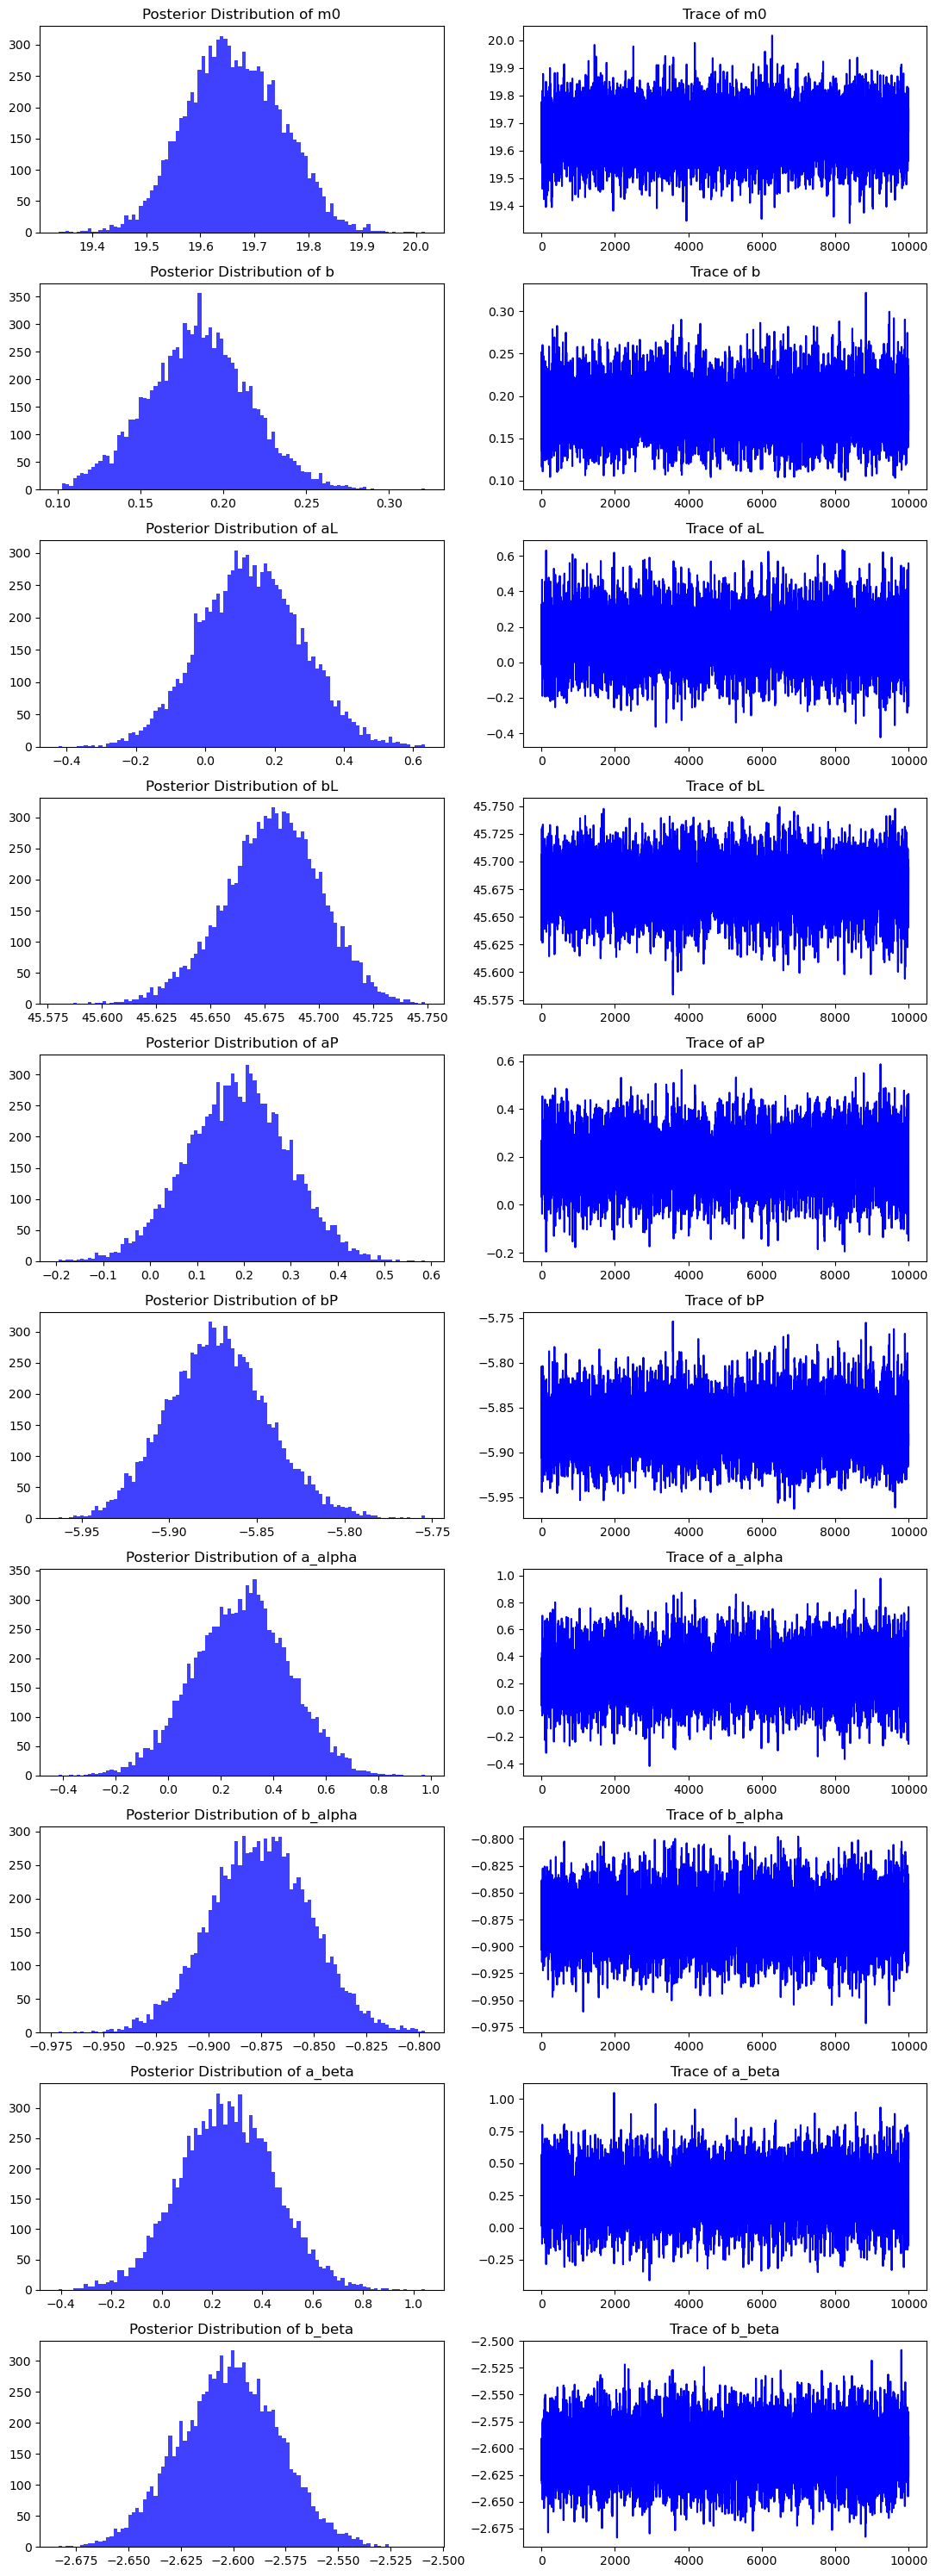

In [20]:
# Extract and save MCMC samples
samples = mcmc.get_samples()
np.savez("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples_evolution2.npz", **samples)

# Construct parameter dictionary
params = {
    'm0': samples['m0'],
    'b': samples['b'],
    'aL': samples['aL'],
    'bL': samples['bL'],
    'aP': samples['aP'],
    'bP': samples['bP'],
    'a_alpha': samples['a_alpha'],
    'b_alpha': samples['b_alpha'],
    'a_beta': samples['a_beta'],
    'b_beta': samples['b_beta'],
}

# Adjust layout to number of parameters
fig, axs = plt.subplots(nrows=len(params), ncols=2, figsize=(11, 3 * len(params)))
axs = axs.reshape(len(params), 2)

# Plotting function
def plot_param(ax_pair, data, title):
    ax_pair[0].hist(data, bins=100, alpha=0.75, color='blue')
    ax_pair[0].set_title(f'Posterior Distribution of {title}')
    ax_pair[1].plot(data, color='blue')
    ax_pair[1].set_title(f'Trace of {title}')

# Loop over parameters and plot
for i, (name, values) in enumerate(params.items()):
    plot_param(axs[i], values, name)

plt.tight_layout()
plt.show()

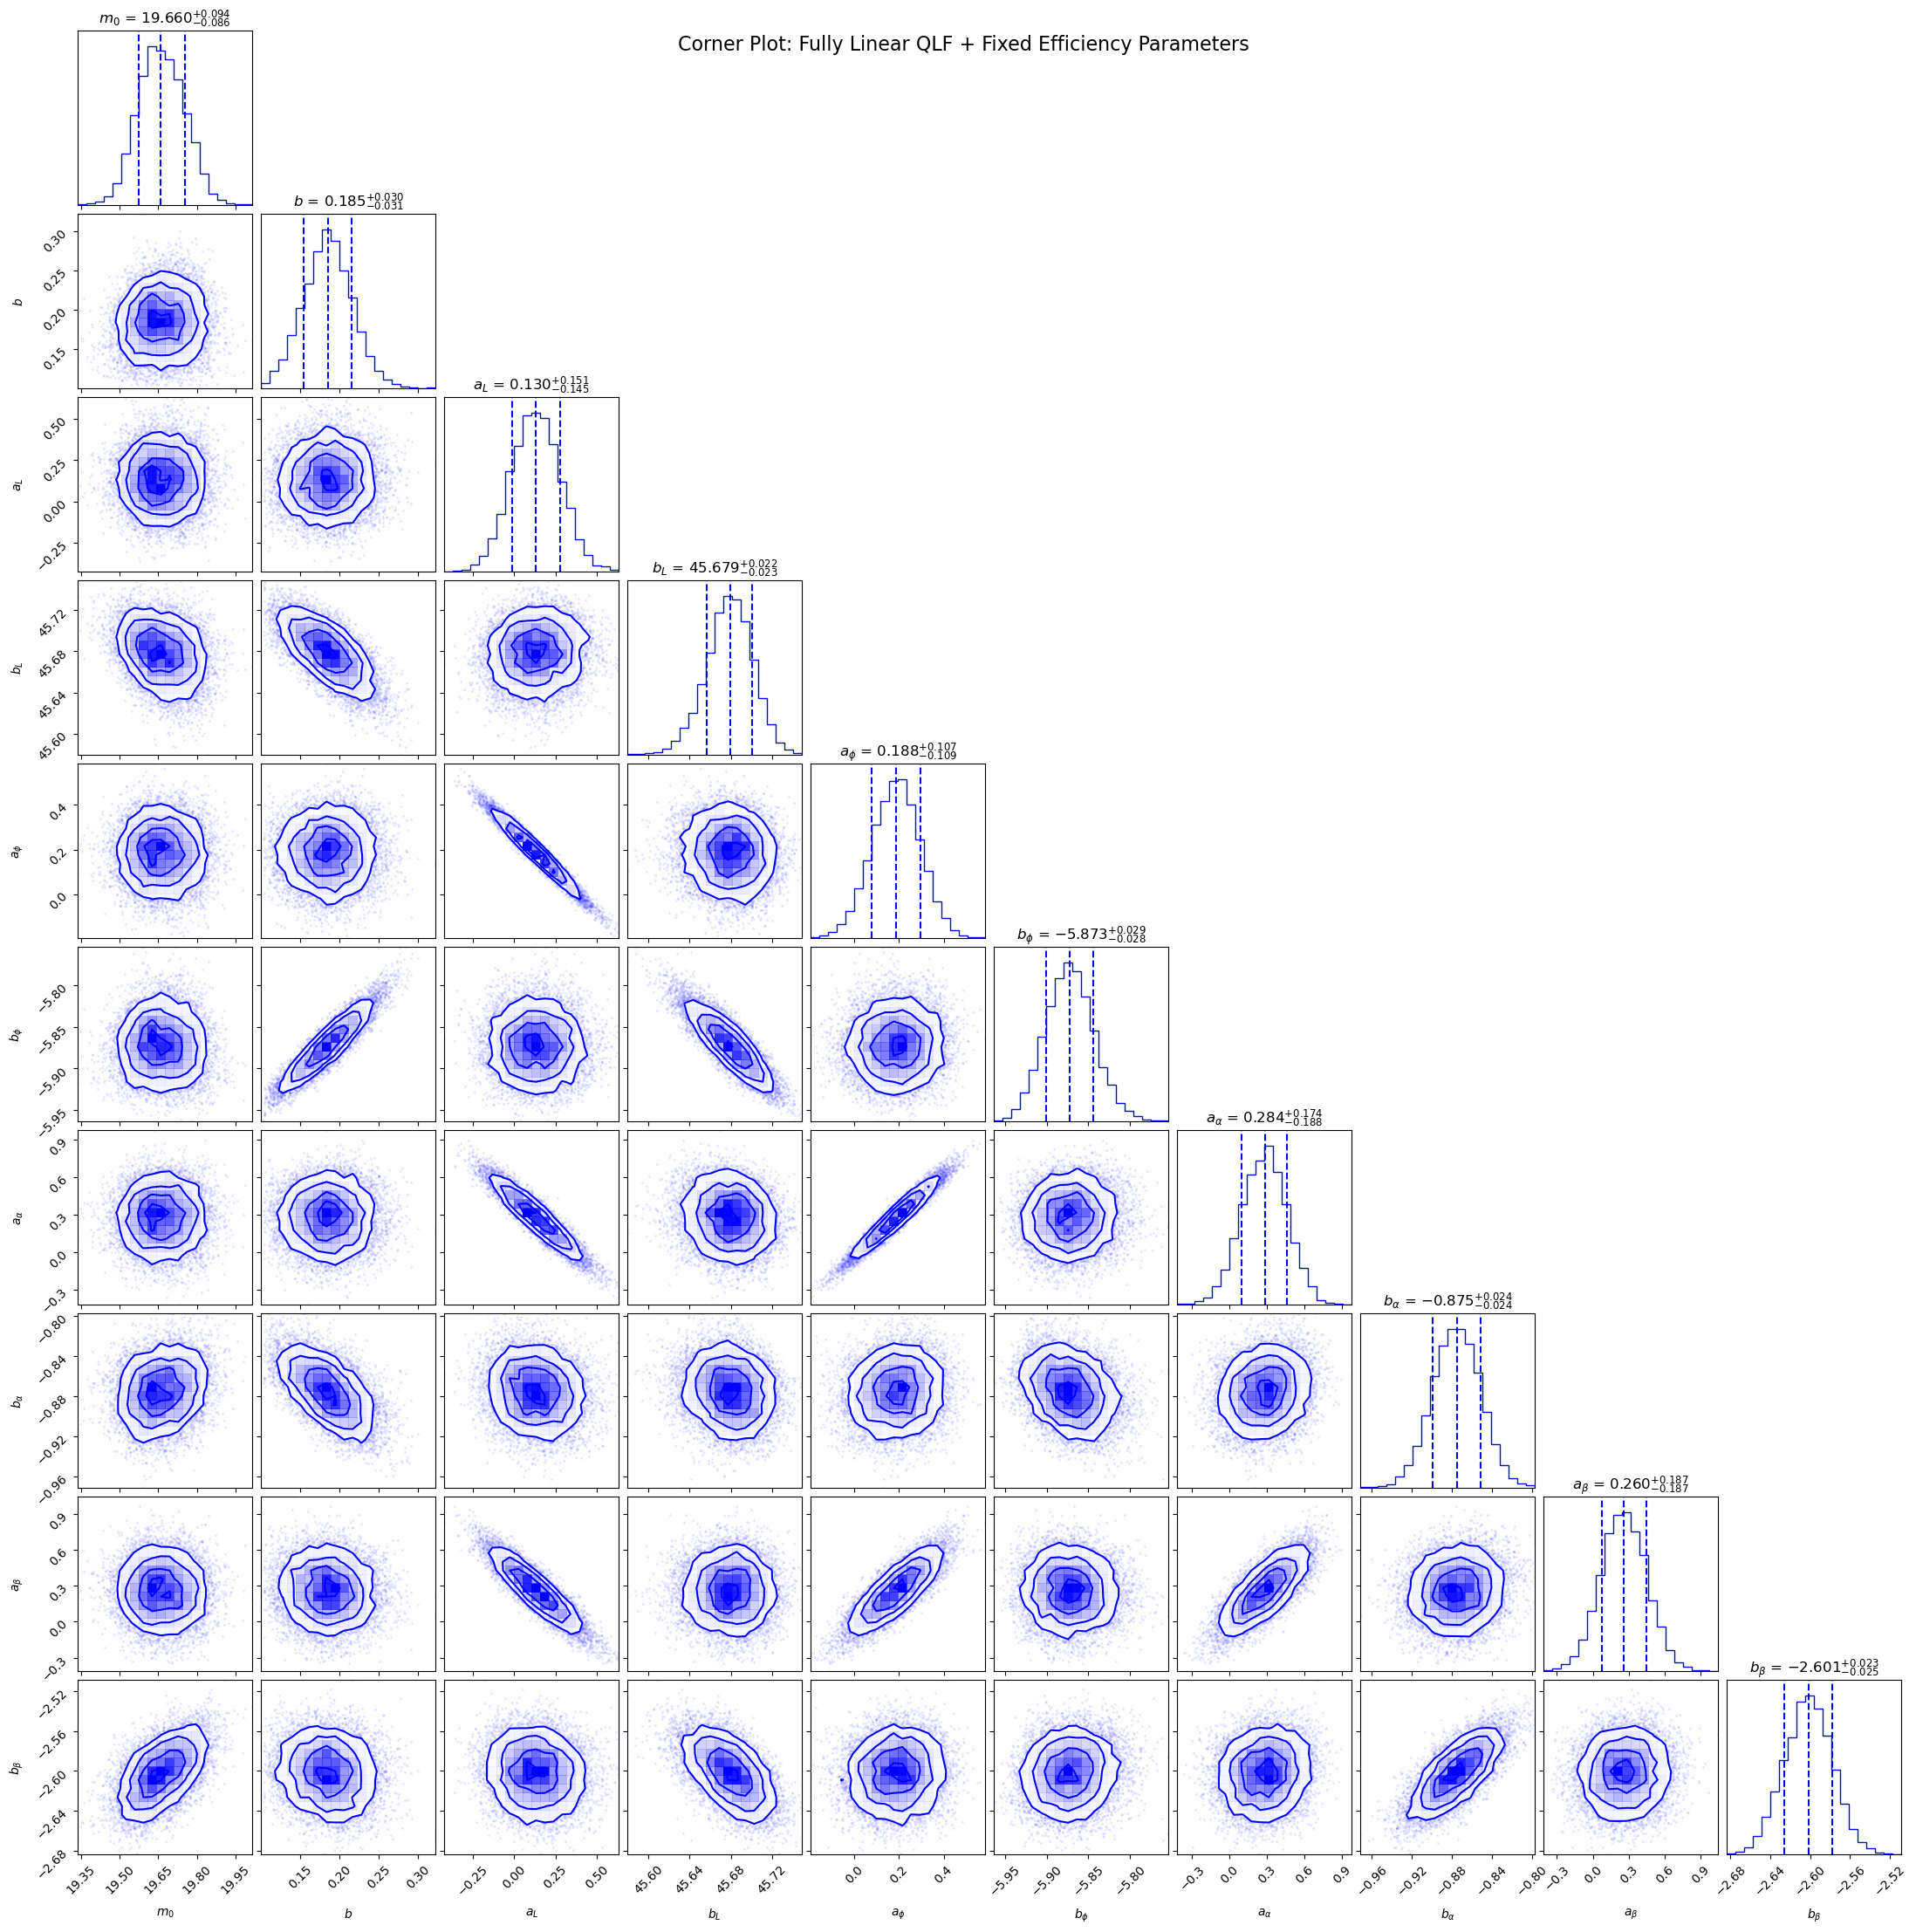

In [21]:
import corner
import matplotlib.pyplot as plt
import numpy as np

samples = mcmc.get_samples()

# Stack only the 10 parameters used in the new model
samples_array = np.vstack((
    samples['m0'], samples['b'],
    samples['aL'], samples['bL'],
    samples['aP'], samples['bP'],
    samples['a_alpha'], samples['b_alpha'],
    samples['a_beta'], samples['b_beta']
)).T

# Corresponding LaTeX-style labels
labels = [
    r"$m_0$", r"$b$",
    r"$a_{L}$", r"$b_{L}$",
    r"$a_{\phi}$", r"$b_{\phi}$",
    r"$a_{\alpha}$", r"$b_{\alpha}$",
    r"$a_{\beta}$", r"$b_{\beta}$"
]

fig = corner.corner(
    samples_array, labels=labels,
    show_titles=True, quantiles=[0.16, 0.5, 0.84],
    plot_contours=True, color='blue',
    title_kwargs={"fontsize": 12}, title_fmt=".3f"
)

fig.suptitle('Corner Plot: Fully Linear QLF + Fixed Efficiency Parameters', fontsize=16)
plt.show()

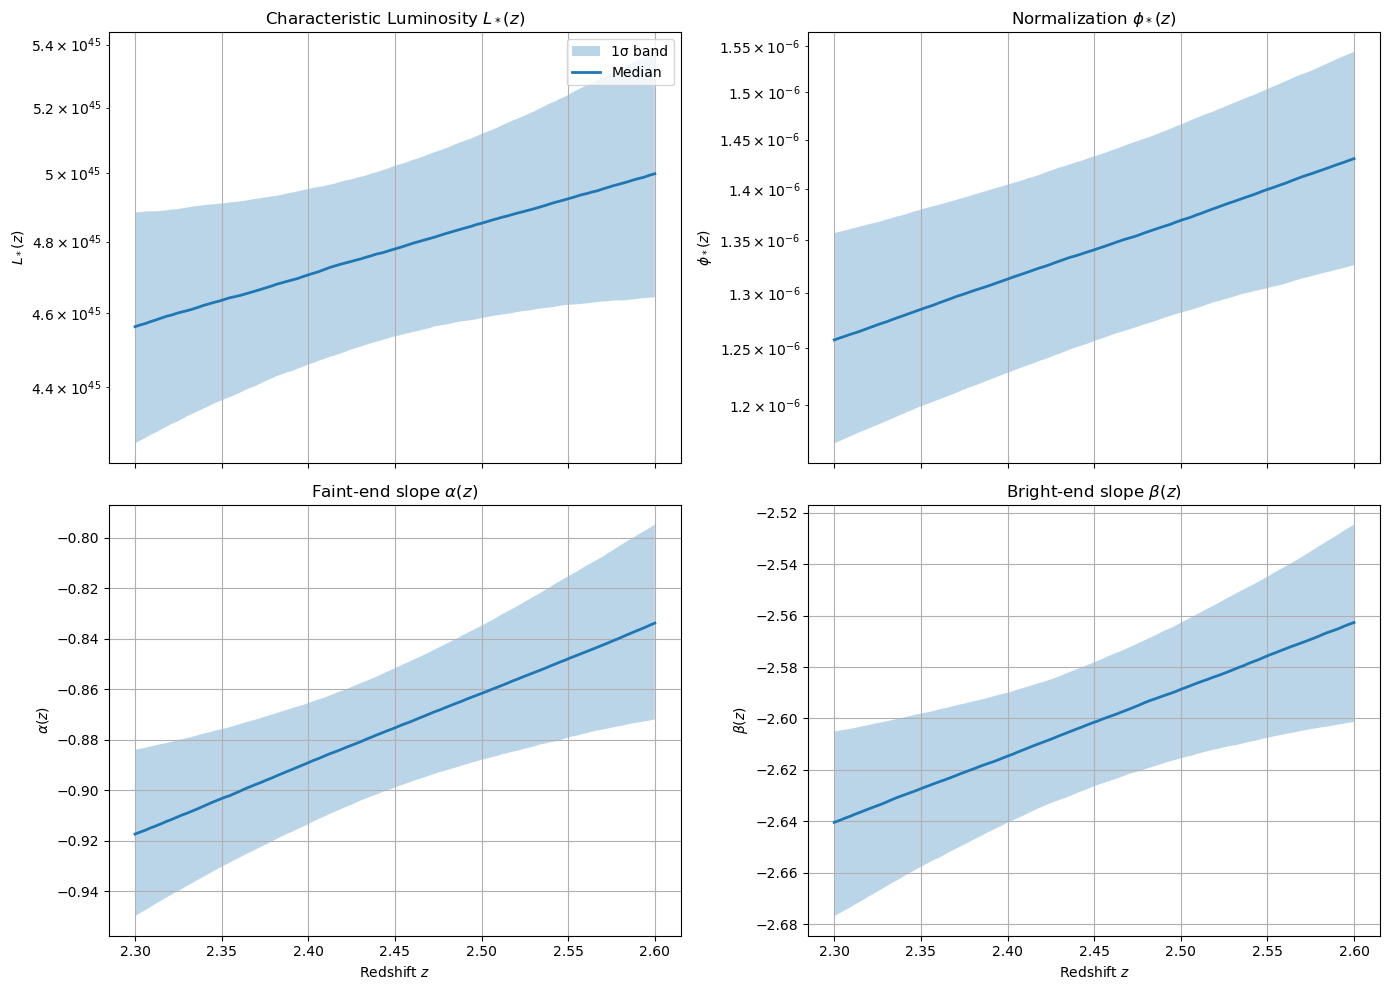

In [22]:
z_grid = np.linspace(2.3, 2.6, 100)
delta_z = z_grid - 2.45

# Linear evolution (new model)
L_star_z = 10 ** (
    samples['aL'][:, None] * delta_z +
    samples['bL'][:, None]
)

phi_star_z = 10 ** (
    samples['aP'][:, None] * delta_z +
    samples['bP'][:, None]
)

alpha_z = (
    samples['a_alpha'][:, None] * delta_z +
    samples['b_alpha'][:, None]
)

beta_z = (
    samples['a_beta'][:, None] * delta_z +
    samples['b_beta'][:, None]
)

# Compute percentiles
def get_percentiles(samples_z):
    median = np.median(samples_z, axis=0)
    p16 = np.percentile(samples_z, 16, axis=0)
    p84 = np.percentile(samples_z, 84, axis=0)
    return median, p16, p84

L_median, L_p16, L_p84 = get_percentiles(L_star_z)
phi_median, phi_p16, phi_p84 = get_percentiles(phi_star_z)
alpha_median, alpha_p16, alpha_p84 = get_percentiles(alpha_z)
beta_median, beta_p16, beta_p84 = get_percentiles(beta_z)

# Plot 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

axs[0, 0].fill_between(z_grid, L_p16, L_p84, alpha=0.3, label='1σ band')
axs[0, 0].plot(z_grid, L_median, lw=2, label='Median')
axs[0, 0].set_yscale('log')
axs[0, 0].set_ylabel(r"$L_*(z)$")
axs[0, 0].set_title(r"Characteristic Luminosity $L_*(z)$")
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].fill_between(z_grid, phi_p16, phi_p84, alpha=0.3)
axs[0, 1].plot(z_grid, phi_median, lw=2)
axs[0, 1].set_yscale('log')
axs[0, 1].set_ylabel(r"$\phi_*(z)$")
axs[0, 1].set_title(r"Normalization $\phi_*(z)$")
axs[0, 1].grid(True)

axs[1, 0].fill_between(z_grid, alpha_p16, alpha_p84, alpha=0.3)
axs[1, 0].plot(z_grid, alpha_median, lw=2)
axs[1, 0].set_ylabel(r"$\alpha(z)$")
axs[1, 0].set_title(r"Faint-end slope $\alpha(z)$")
axs[1, 0].set_xlabel("Redshift $z$")
axs[1, 0].grid(True)

axs[1, 1].fill_between(z_grid, beta_p16, beta_p84, alpha=0.3)
axs[1, 1].plot(z_grid, beta_median, lw=2)
axs[1, 1].set_ylabel(r"$\beta(z)$")
axs[1, 1].set_title(r"Bright-end slope $\beta(z)$")
axs[1, 1].set_xlabel("Redshift $z$")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()